In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
url = "https://raw.githubusercontent.com/jeiloh/SDS384-Project/main/data/merged_df.csv"

# use pandas read_csv function to import the CSV file
merged_df = pd.read_csv(url)

# print the first few rows of the DataFrame
print(merged_df.head())

   Census Tract Start  Day of Week  Hour  Month  num_trips      TractId  \
0         48021950100            4    18      6          1  48021950100   
1         48021950300            1    15      5          1  48021950300   
2         48021950300            1    22      8          1  48021950300   
3         48021950300            2    20      2          1  48021950300   
4         48021950300            3    23      8          1  48021950300   

   State          County  TotalPop   Men  ...  Walk  OtherTransp  WorkAtHome  \
0  Texas  Bastrop County      8334  4088  ...   0.4          1.1         6.0   
1  Texas  Bastrop County     15255  7591  ...   0.7          1.4         5.8   
2  Texas  Bastrop County     15255  7591  ...   0.7          1.4         5.8   
3  Texas  Bastrop County     15255  7591  ...   0.7          1.4         5.8   
4  Texas  Bastrop County     15255  7591  ...   0.7          1.4         5.8   

   MeanCommute  Employed  PrivateWork  PublicWork  SelfEmployed  Fam

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt  
import matplotlib

from scipy import stats
import xgboost

import seaborn as sns

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

In [11]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

In [19]:
merged_df = merged_df.dropna()

In [20]:
merged_df.shape

(106956, 42)

In [21]:
features = ['Census Tract Start', 'Day of Week','Hour','TotalPop', 'Hispanic', 'White', 'Black',
       'Native', 'Asian', 'Pacific', 'VotingAgeCitizen', 'Income', 'IncomeErr',
       'IncomePerCap', 'IncomePerCapErr', 'Poverty', 'ChildPoverty',
       'Professional', 'Service', 'Office', 'Construction', 'Production',
       'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork', 'SelfEmployed',
       'FamilyWork', 'Unemployment']
dependent_var = ['num_trips']

In [22]:
merged_df['Census Tract Start'] = merged_df['Census Tract Start'].astype(int)

In [23]:
X = merged_df[features]
y = merged_df[dependent_var]

In [24]:
y = np.array(y)

In [25]:
max_depth_array = [2, 3, 4, 5, 6, 7, 8, 9, 10]

mse_mean = []
mse_std = []
for max_depth in max_depth_array:
    
    rf_mse = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.33, random_state=i*10 + 4)
        model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rf_mse += [mse]

    print("max_depth %i -- MSE : %0.3f +- %0.3f"%(max_depth, np.mean(rf_mse), np.std(rf_mse)))
    mse_mean += [np.mean(rf_mse)]
    mse_std += [np.std(rf_mse)]

max_depth 2 -- MSE : 22352.665 +- 1566.526
max_depth 3 -- MSE : 15602.392 +- 1170.643
max_depth 4 -- MSE : 12505.287 +- 1165.050
max_depth 5 -- MSE : 11075.112 +- 1132.769
max_depth 6 -- MSE : 10363.962 +- 1181.561
max_depth 7 -- MSE : 10337.478 +- 1211.852
max_depth 8 -- MSE : 10275.721 +- 1268.345
max_depth 9 -- MSE : 10247.920 +- 1259.955
max_depth 10 -- MSE : 10231.119 +- 1231.045


In [26]:
max_depth_array = [2, 3, 4, 5, 6, 7, 8, 9, 10]

mse_xg_mean = []
mse_xg_std = []
for max_depth in max_depth_array:
    
    mse_xg = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.33, random_state=i*10 + 4)
        model = xgboost.XGBRegressor(max_depth=max_depth).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse_xg += [mean_squared_error(y_test, y_pred)]

    print("max_depth %i -- MSE : %0.3f +- %0.3f"%(max_depth, np.mean(mse_xg), np.std(mse_xg)))
    mse_xg_mean += [np.mean(mse_xg)]
    mse_xg_std += [np.std(mse_xg)]

max_depth 2 -- MSE : 12692.905 +- 1193.802
max_depth 3 -- MSE : 9758.919 +- 1200.816
max_depth 4 -- MSE : 9192.110 +- 1141.620
max_depth 5 -- MSE : 9495.408 +- 1205.139
max_depth 6 -- MSE : 9875.973 +- 1237.876
max_depth 7 -- MSE : 10145.741 +- 1242.938
max_depth 8 -- MSE : 10268.587 +- 1255.265
max_depth 9 -- MSE : 10315.582 +- 1255.913
max_depth 10 -- MSE : 10334.690 +- 1255.418


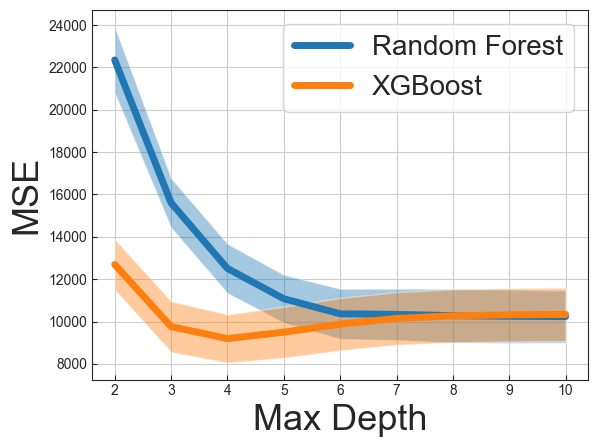

In [27]:
sns.set_style("ticks", {'axes.facecolor': 'white',  'figure.facecolor': 'white', 'legend.fontsize': 30, "xtick.direction": "in","ytick.direction": "in"})

plt.plot(max_depth_array, mse_mean, lw=5.0, label='Random Forest')
plt.fill_between(max_depth_array, np.array(mse_mean)+mse_std,  np.array(mse_mean)-mse_std, alpha=0.4)

plt.plot(max_depth_array, mse_xg_mean, lw=5.0, label='XGBoost')
plt.fill_between(max_depth_array, np.array(mse_xg_mean)+mse_xg_std,  np.array(mse_xg_mean)-mse_xg_std, alpha=0.4)


plt.legend(loc='best', prop={'size':20})
plt.ylabel('MSE', size=26)
plt.xlabel('Max Depth', size=26)
plt.grid()

In [28]:
model = xgboost.XGBRegressor(max_depth=4).fit(X, y)

In [29]:
y_pred = model.predict(X)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

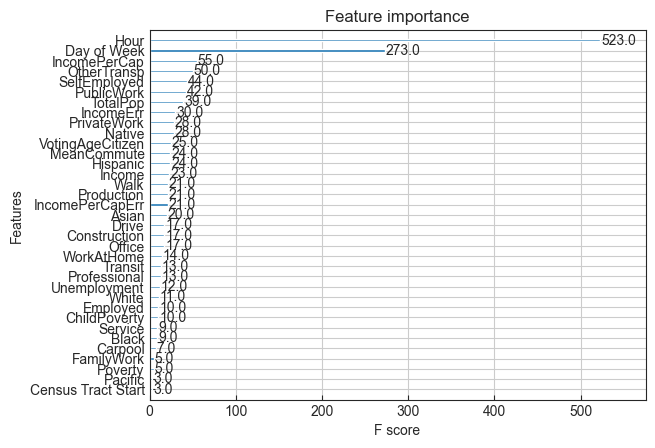

In [30]:
from xgboost import plot_importance
plot_importance(model)

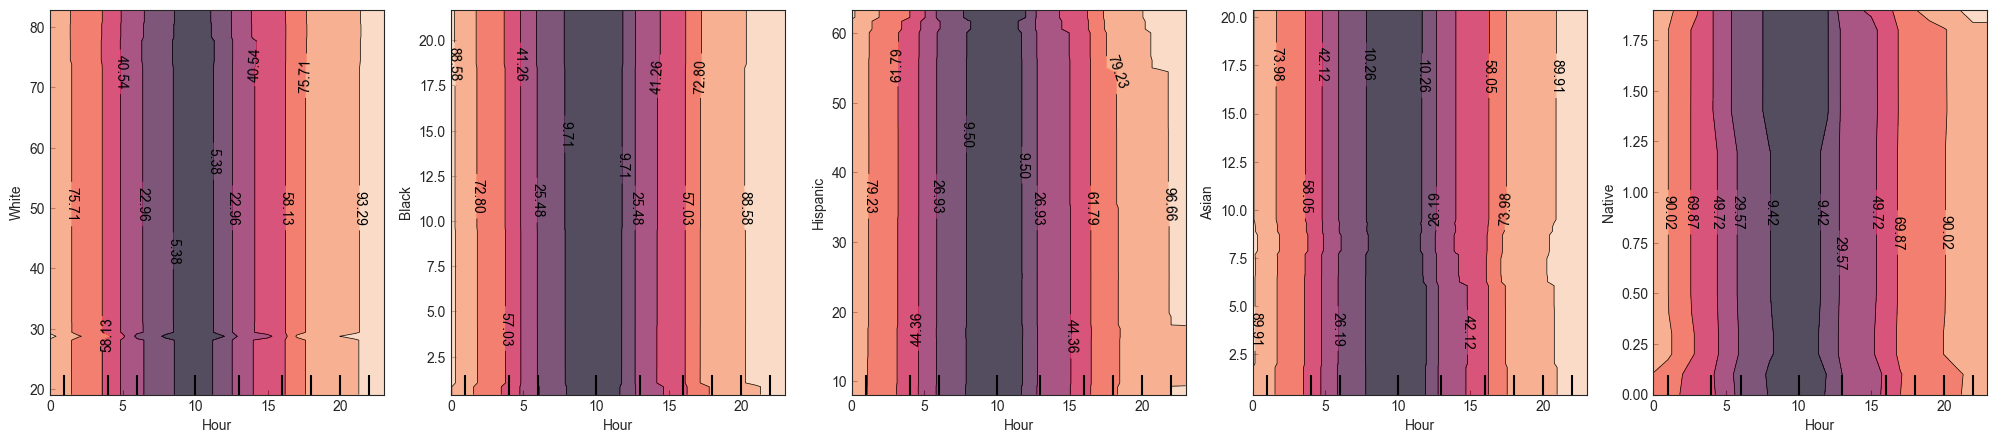

In [33]:
fig, ax = plt.subplots(1, 5, figsize=(25, 5))
features_PDP_2D = [('Hour', 'White')]
PartialDependenceDisplay.from_estimator(model, X, features_PDP_2D, ax=ax[0], kind='average')
ax[0].set_ylabel('Hispanic Ratio', size=14)
ax[0].set_xlabel('Hour (h)', size=14)
ax[0].grid()

features_PDP_2D = [('Hour', 'Black')]
PartialDependenceDisplay.from_estimator(model, X, features_PDP_2D, ax=ax[1], kind='average')
ax[1].set_ylabel('Hispanic Ratio', size=14)
ax[1].set_xlabel('Hour (h)', size=14)
ax[1].grid()

features_PDP_2D = [('Hour', 'Hispanic')]
PartialDependenceDisplay.from_estimator(model, X, features_PDP_2D, ax=ax[2], kind='average')
ax[2].set_ylabel('Hispanic Ratio', size=14)
ax[2].set_xlabel('Hour (h)', size=14)
ax[2].grid()

features_PDP_2D = [('Hour', 'Asian')]
PartialDependenceDisplay.from_estimator(model, X, features_PDP_2D, ax=ax[3], kind='average')
ax[3].set_ylabel('Hispanic Ratio', size=14)
ax[3].set_xlabel('Hour (h)', size=14)
ax[3].grid()

features_PDP_2D = [('Hour', 'Native')]
PartialDependenceDisplay.from_estimator(model, X, features_PDP_2D, ax=ax[4], kind='average')
ax[4].set_ylabel('Hispanic Ratio', size=14)
ax[4].set_xlabel('Hour (h)', size=14)
ax[4].grid()

In [34]:
import shap

In [35]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


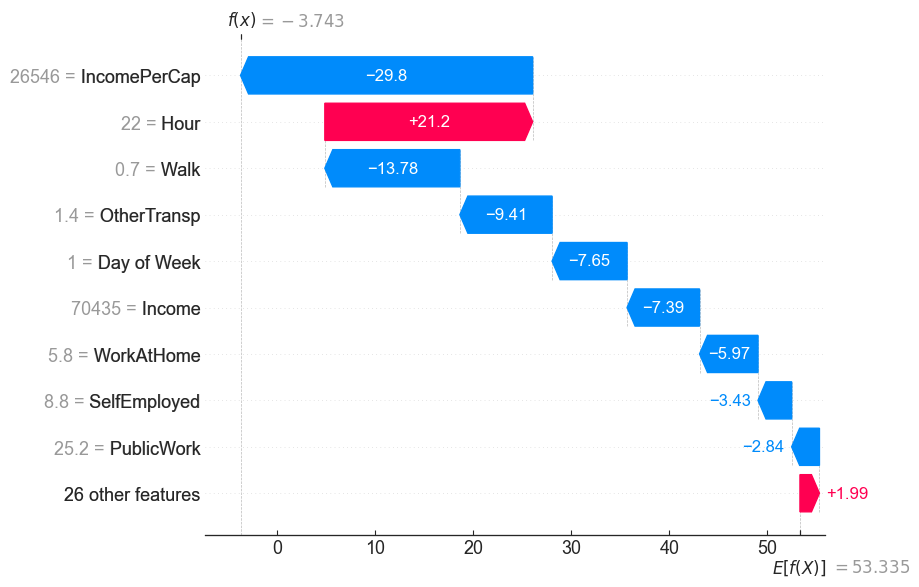

In [36]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[2])

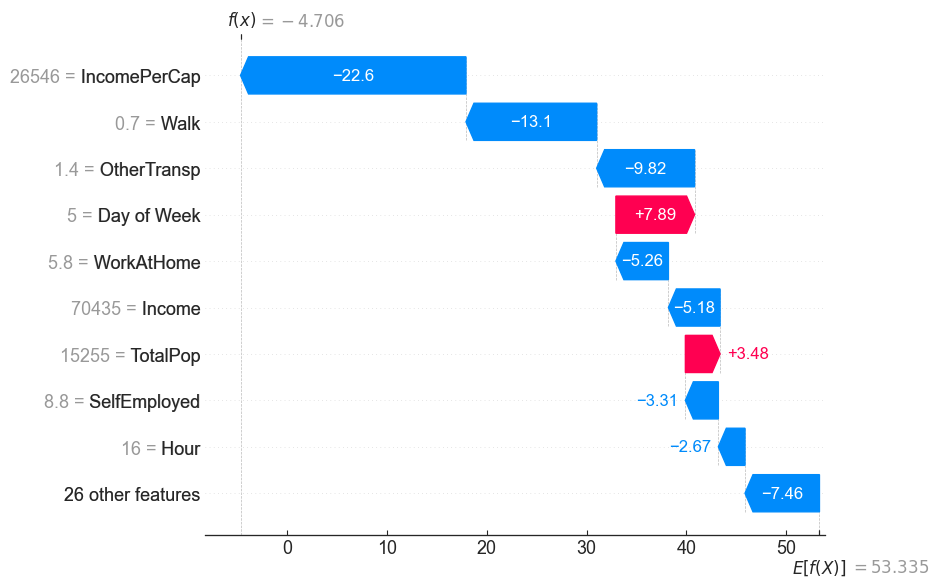

In [37]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[5])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


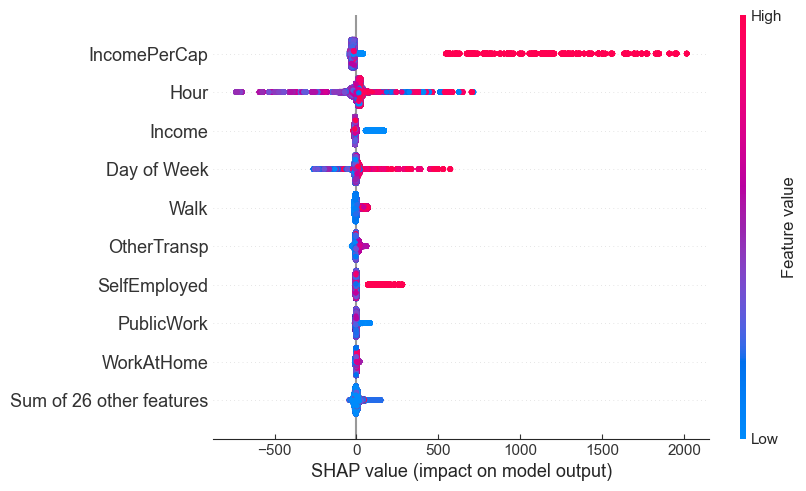

In [38]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

# Without Downtown

In [39]:
# create a list of TractIds you want to drop
tractIds_to_drop = [48453001100]

# drop rows with these TractIds
df = merged_df[~merged_df['TractId'].isin(tractIds_to_drop)]

In [40]:
X = df[features]
y = df[dependent_var]

In [42]:
y = np.array(y)

In [43]:
max_depth_array = [2, 3, 4, 5, 6, 7, 8, 9, 10]

mse_mean = []
mse_std = []
for max_depth in max_depth_array:
    
    rf_mse = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.33, random_state=i*10 + 4)
        model = RandomForestRegressor(max_depth=max_depth).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rf_mse += [mse]

    print("max_depth %i -- MSE : %0.3f +- %0.3f"%(max_depth, np.mean(rf_mse), np.std(rf_mse)))
    mse_mean += [np.mean(rf_mse)]
    mse_std += [np.std(rf_mse)]

max_depth 2 -- MSE : 4284.455 +- 159.595
max_depth 3 -- MSE : 3575.335 +- 155.556
max_depth 4 -- MSE : 2822.060 +- 124.577
max_depth 5 -- MSE : 2440.304 +- 96.884
max_depth 6 -- MSE : 2167.092 +- 101.898
max_depth 7 -- MSE : 1889.019 +- 85.089
max_depth 8 -- MSE : 1743.862 +- 77.691
max_depth 9 -- MSE : 1696.140 +- 69.468
max_depth 10 -- MSE : 1683.643 +- 66.836


In [44]:
max_depth_array = [2, 3, 4, 5, 6, 7, 8, 9, 10]

mse_xg_mean = []
mse_xg_std = []
for max_depth in max_depth_array:
    
    mse_xg = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.33, random_state=i*10 + 4)
        model = xgboost.XGBRegressor(max_depth=max_depth).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse_xg += [mean_squared_error(y_test, y_pred)]

    print("max_depth %i -- MSE : %0.3f +- %0.3f"%(max_depth, np.mean(mse_xg), np.std(mse_xg)))
    mse_xg_mean += [np.mean(mse_xg)]
    mse_xg_std += [np.std(mse_xg)]

max_depth 2 -- MSE : 2485.030 +- 121.786
max_depth 3 -- MSE : 1839.961 +- 94.219
max_depth 4 -- MSE : 1630.488 +- 73.687
max_depth 5 -- MSE : 1578.381 +- 64.812
max_depth 6 -- MSE : 1612.330 +- 62.080
max_depth 7 -- MSE : 1671.180 +- 64.306
max_depth 8 -- MSE : 1720.337 +- 66.144
max_depth 9 -- MSE : 1746.339 +- 65.386
max_depth 10 -- MSE : 1756.126 +- 65.658


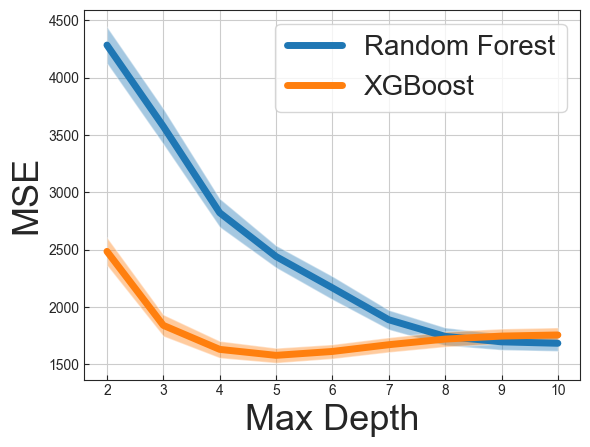

In [45]:
sns.set_style("ticks", {'axes.facecolor': 'white',  'figure.facecolor': 'white', 'legend.fontsize': 30, "xtick.direction": "in","ytick.direction": "in"})

plt.plot(max_depth_array, mse_mean, lw=5.0, label='Random Forest')
plt.fill_between(max_depth_array, np.array(mse_mean)+mse_std,  np.array(mse_mean)-mse_std, alpha=0.4)

plt.plot(max_depth_array, mse_xg_mean, lw=5.0, label='XGBoost')
plt.fill_between(max_depth_array, np.array(mse_xg_mean)+mse_xg_std,  np.array(mse_xg_mean)-mse_xg_std, alpha=0.4)


plt.legend(loc='best', prop={'size':20})
plt.ylabel('MSE', size=26)
plt.xlabel('Max Depth', size=26)
plt.grid()

In [46]:
model = xgboost.XGBRegressor(max_depth=5).fit(X, y)

In [47]:
y_pred = model.predict(X)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

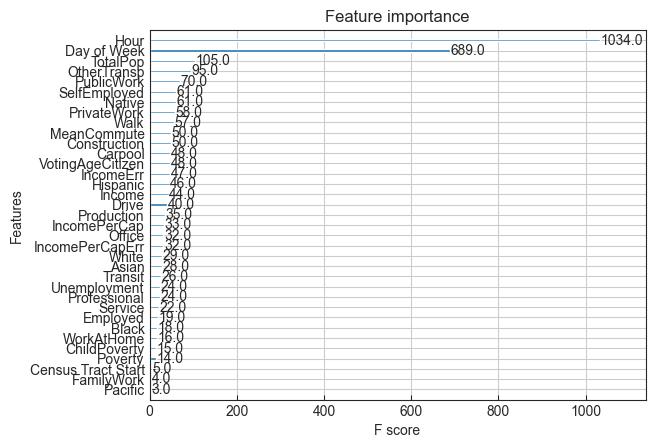

In [48]:
from xgboost import plot_importance
plot_importance(model)

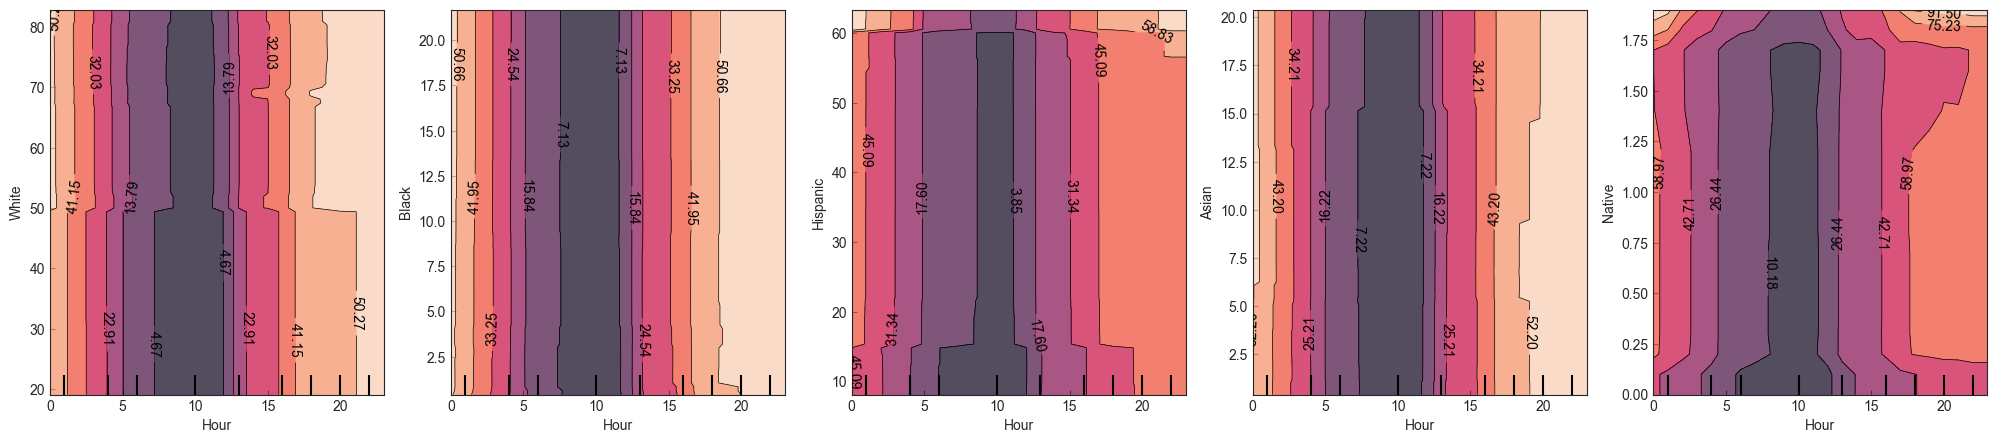

In [49]:
fig, ax = plt.subplots(1, 5, figsize=(25, 5))
features_PDP_2D = [('Hour', 'White')]
PartialDependenceDisplay.from_estimator(model, X, features_PDP_2D, ax=ax[0], kind='average')
ax[0].set_ylabel('Hispanic Ratio', size=14)
ax[0].set_xlabel('Hour (h)', size=14)
ax[0].grid()

features_PDP_2D = [('Hour', 'Black')]
PartialDependenceDisplay.from_estimator(model, X, features_PDP_2D, ax=ax[1], kind='average')
ax[1].set_ylabel('Hispanic Ratio', size=14)
ax[1].set_xlabel('Hour (h)', size=14)
ax[1].grid()

features_PDP_2D = [('Hour', 'Hispanic')]
PartialDependenceDisplay.from_estimator(model, X, features_PDP_2D, ax=ax[2], kind='average')
ax[2].set_ylabel('Hispanic Ratio', size=14)
ax[2].set_xlabel('Hour (h)', size=14)
ax[2].grid()

features_PDP_2D = [('Hour', 'Asian')]
PartialDependenceDisplay.from_estimator(model, X, features_PDP_2D, ax=ax[3], kind='average')
ax[3].set_ylabel('Hispanic Ratio', size=14)
ax[3].set_xlabel('Hour (h)', size=14)
ax[3].grid()

features_PDP_2D = [('Hour', 'Native')]
PartialDependenceDisplay.from_estimator(model, X, features_PDP_2D, ax=ax[4], kind='average')
ax[4].set_ylabel('Hispanic Ratio', size=14)
ax[4].set_xlabel('Hour (h)', size=14)
ax[4].grid()